# Initial Setup

In [173]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from IPython.display import Audio
sound_file = '../sound/done.mp3'
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(
    ip,
    require_interaction=True
))
# %load_ext jupyternotify

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
# sys.path.insert(0, '../code')
# sys.path.insert(0, '../auth')
# sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key, api_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

## Get NYSE calendar

In [3]:
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early;

## Set up Frequency Variables

### Custom Business Hour

In [4]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [6]:
cbd = pd.offsets.CustomBusinessDay(calendar=NYSE)
cbd

<CustomBusinessDay>

# YFinance Futures

## Setup / Gather Data

In [7]:
ticker = 'ES=F'

In [18]:
# spy_f_df = yf.download(ticker, start='2018-05-01', end='2021-05-01', progress=False)
# spy_f_df.index = spy_f_df.index.rename('date')
# spy_f_df.columns = ['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume']
# spy_f_df.to_csv('../data/SPY_F_3Y_CBD.csv')

In [16]:
# spy_f_df = yf.download(ticker, start='2016-05-01', end='2021-05-01', progress=False)
# spy_f_df.index = spy_f_df.index.rename('date')
# spy_f_df.columns = ['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume']
# spy_f_df.to_csv('../data/SPY_F_5Y_CBD.csv')

In [17]:
# spy_f_df = yf.download(ticker, start='2011-05-01', end='2021-05-01', progress=False)
# spy_f_df.index = spy_f_df.index.rename('date')
# spy_f_df.columns = ['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume']
# spy_f_df.to_csv('../data/SPY_F_10Y_CBD.csv')

## Load Data from File

### 3Y

In [22]:
spy_df_3Y = pd.read_csv('../data/SPY_3Y_CBD.csv', index_col='date')
spy_df_3Y.index = pd.to_datetime(spy_df_3Y.index)

In [19]:
spy_f_df_3Y = pd.read_csv('../data/SPY_F_3Y_CBD.csv', index_col='date')
spy_f_df_3Y.index = pd.to_datetime(spy_f_df_3Y.index)

### 5Y

In [20]:
spy_f_df_5Y = pd.read_csv('../data/SPY_F_5Y_CBD.csv', index_col='date')
spy_f_df_5Y.index = pd.to_datetime(spy_f_df_5Y.index)

### 10Y

In [21]:
spy_f_df_10Y = pd.read_csv('../data/SPY_F_10Y_CBD.csv', index_col='date')
spy_f_df_10Y.index = pd.to_datetime(spy_f_df_10Y.index)

## Data Preparation

### EDA

In [23]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919
...,...,...,...,...,...,...
2021-04-26,4170.75,4186.00,4163.75,4179.50,4179.50,1019731
2021-04-27,4181.50,4192.50,4166.75,4179.00,4179.00,992029
2021-04-28,4180.25,4193.75,4172.75,4176.25,4176.25,1282972


In [24]:
spy_df_3Y.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

### Set up Frequency

In [52]:
spy_df_3Y = spy_df_3Y.asfreq(cbd)

In [25]:
spy_f_df_3Y = spy_f_df_3Y.asfreq(cbd)
spy_f_df_5Y = spy_f_df_5Y.asfreq(cbd)
spy_f_df_10Y = spy_f_df_10Y.asfreq(cbd)

In [27]:
spy_f_df_5Y.isna().sum()

f_open         58
f_high         58
f_low          58
f_close        58
f_adj_close    58
f_volume       58
dtype: int64

### Impute Missing Values

In [137]:
spy_df_3Y = spy_df_3Y.interpolate()
spy_f_df_3Y = spy_f_df_3Y.interpolate()
spy_f_df_5Y = spy_f_df_5Y.interpolate()
spy_f_df_10Y = spy_f_df_10Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [30]:
df_f_3Y_close = spy_f_df_3Y.f_close
df_f_3Y_vol = spy_f_df_3Y.f_volume
df_f_5Y_close = spy_f_df_5Y.f_close
df_f_5Y_vol = spy_f_df_5Y.f_volume
df_f_10Y_close = spy_f_df_10Y.f_close
df_f_10Y_vol = spy_f_df_10Y.f_volume

In [31]:
df_f_5Y_close, df_f_5Y_vol

(date
 2016-05-02    2074.25
 2016-05-03    2057.00
 2016-05-04    2047.00
 2016-05-05    2044.00
 2016-05-06    2052.75
                ...   
 2021-04-26    4179.50
 2021-04-27    4179.00
 2021-04-28    4176.25
 2021-04-29    4203.50
 2021-04-30    4174.50
 Freq: C, Name: f_close, Length: 1305, dtype: float64,
 date
 2016-05-02    1306173.0
 2016-05-03    1827577.0
 2016-05-04    1557981.0
 2016-05-05    1433289.0
 2016-05-06    1813432.0
                 ...    
 2021-04-26    1019731.0
 2021-04-27     992029.0
 2021-04-28    1282972.0
 2021-04-29    1746965.0
 2021-04-30    1746965.0
 Freq: C, Name: f_volume, Length: 1305, dtype: float64)

## Check Correlations between SPY and SPY Futures

In [76]:
spy_cat_3Y_df = spy_df_3Y.join(spy_f_df_3Y)
df = spy_cat_3Y_df
df

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0,4180.25,4193.75,4172.75,4176.25,4176.25,1282972.0


In [83]:
spy_f_df_3Y

,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-01,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-02,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-03,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-04,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-07,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-04-26,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0
2021-04-27,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0
2021-04-28,4180.25,4193.75,4172.75,4176.25,4176.25,1282972.0


In [138]:
spy_f_df_3Y_1d_back = spy_f_df_3Y.copy()
spy_f_df_3Y_1d_back.index = spy_f_df_3Y_1d_back.index+cbd
# spy_f_df_3Y_1d_back.drop(spy_f_df_3Y_1d_back.index[-1], axis=0, inplace=True)
spy_f_df_3Y_1d_back

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:702: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,
2018-05-02,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-03,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-04,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-07,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
2018-05-08,2662.75,2681.50,2661.25,2670.00,2670.00,1148919.0
...,...,...,...,...,...,...
2021-04-27,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0
2021-04-28,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0
2021-04-29,4180.25,4193.75,4172.75,4176.25,4176.25,1282972.0


Timestamp('2021-05-03 00:00:00')

In [64]:
df_diff = pd.DataFrame(index = df.index)

In [68]:
df_diff['d_close'] = df.close.diff()
df_diff['d_f_close'] = df.f_close.diff()
df_diff['d_open'] = df.open.diff()
df_diff['d_f_open'] = df.f_open.diff()

In [69]:
df_diff

,d_close,d_f_close,d_open,d_f_open
date,,,,
2018-05-02,-1.779999,-24.75,0.890015,9.25
2018-05-03,-0.580017,4.25,-2.500000,-28.75
2018-05-04,3.399994,31.25,-0.740021,5.00
2018-05-07,0.900024,7.00,5.370026,31.00
2018-05-08,0.000000,0.25,-0.390015,5.25
...,...,...,...,...
2021-04-26,0.869995,8.00,4.570007,41.75
2021-04-27,-0.089996,-0.50,0.489990,10.75
2021-04-28,-0.119995,-2.75,-0.119995,-1.25


In [79]:
spy_df_3Y

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0
...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0


In [139]:
df_1d_back = spy_df_3Y.copy()
df_1d_back = df_1d_back.join(spy_f_df_3Y_1d_back)
df_1d_back

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume
date,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0,4129.00,4186.75,4127.50,4171.50,4171.50,1509514.0
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0


In [61]:
df.dropna(inplace=True)

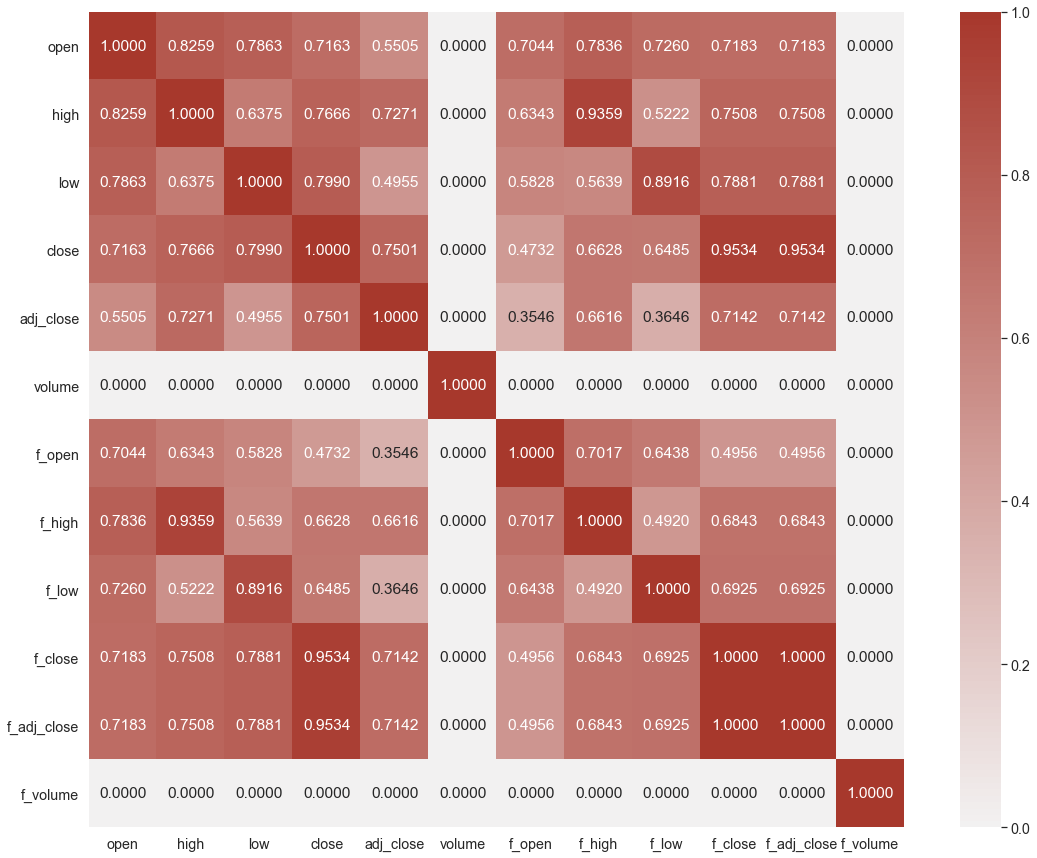

In [70]:
matrix = df.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**150, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

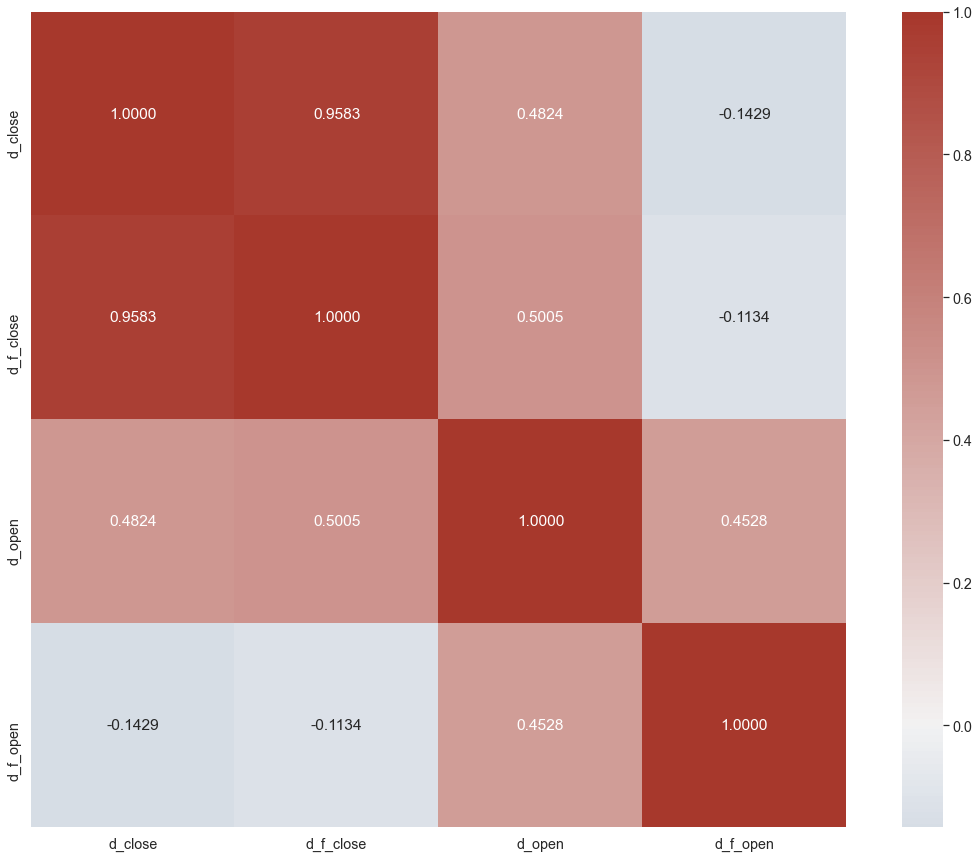

In [72]:
matrix = df_diff.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

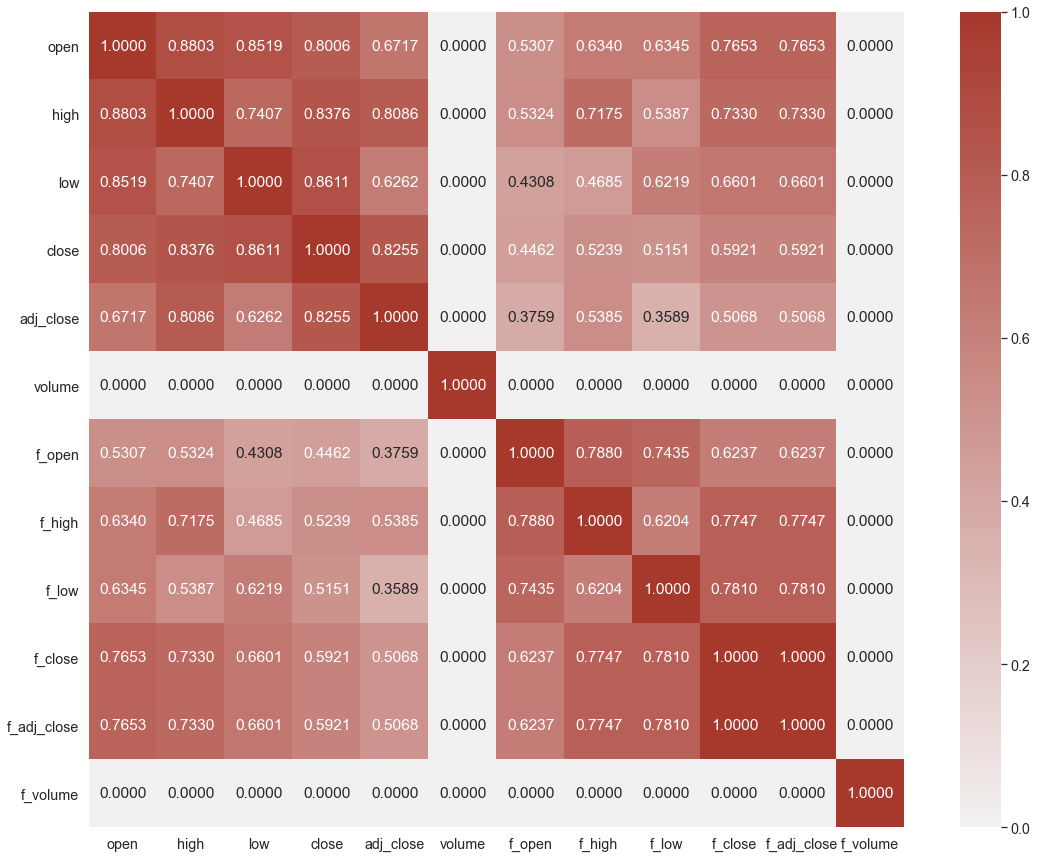

In [123]:
matrix = df_1d_back.corr()
# Create a mask
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 15))
sns.set(font_scale=1.3) 
sns.heatmap(matrix**100, center=0, annot=True, #mask=mask,
             fmt='.4f', square=True, cmap=cmap, ax=ax)
plt.savefig('../images/spy_vs_spy_f_corr_matrix.png')

## Logistic Regression

In [165]:
y_setup = df_1d_back.copy()
y_setup['close_diff'] = y_setup.close.diff()
y_setup['change'] = np.where(y_setup.close_diff >= 0, 1, 0)
y_setup

,open,high,low,close,adj_close,volume,f_open,f_high,f_low,f_close,f_adj_close,f_volume,close_diff,change
date,,,,,,,,,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900.0,2646.25,2658.00,2623.25,2652.25,2652.25,1323628.0,-1.779999,0
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500.0,2655.50,2658.50,2624.25,2627.50,2627.50,1427995.0,-0.580017,0
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100.0,2626.75,2636.25,2591.25,2631.75,2631.75,2146587.0,3.399994,1
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900.0,2631.75,2669.50,2612.25,2663.00,2663.00,1699202.0,0.900024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400.0,4129.00,4186.75,4127.50,4171.50,4171.50,1509514.0,0.869995,1
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100.0,4170.75,4186.00,4163.75,4179.50,4179.50,1019731.0,-0.089996,0
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900.0,4181.50,4192.50,4166.75,4179.00,4179.00,992029.0,-0.119995,0


In [167]:
X = df_1d_back.drop(['close', 'adj_close', 'open', 'high', 'low', 'volume'], axis=1)
X = X.drop(X.index[0], axis=0)
y = y_setup.drop(y_setup.index[0]).change
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = .20,
        random_state = 729)
print (X,y)

             f_open   f_high    f_low  f_close  f_adj_close   f_volume
date                                                                  
2018-05-02  2646.25  2658.00  2623.25  2652.25      2652.25  1323628.0
2018-05-03  2655.50  2658.50  2624.25  2627.50      2627.50  1427995.0
2018-05-04  2626.75  2636.25  2591.25  2631.75      2631.75  2146587.0
2018-05-07  2631.75  2669.50  2612.25  2663.00      2663.00  1699202.0
2018-05-08  2662.75  2681.50  2661.25  2670.00      2670.00  1148919.0
...             ...      ...      ...      ...          ...        ...
2021-04-26  4129.00  4186.75  4127.50  4171.50      4171.50  1509514.0
2021-04-27  4170.75  4186.00  4163.75  4179.50      4179.50  1019731.0
2021-04-28  4181.50  4192.50  4166.75  4179.00      4179.00   992029.0
2021-04-29  4180.25  4193.75  4172.75  4176.25      4176.25  1282972.0
2021-04-30  4184.75  4211.00  4168.00  4203.50      4203.50  1746965.0

[783 rows x 6 columns] date
2018-05-02    0
2018-05-03    0
2018-05-04    1


In [168]:
y.isna().sum()

0

In [169]:
numerical_pipeline = Pipeline(steps=[
    ('rs', RobustScaler())
])
                
# categorical_pipeline = Pipeline(steps=[
#     ('ohe', OneHotEncoder( #drop='first',
#                          sparse=False,
#                          handle_unknown='ignore'))
# ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train.columns),
#     ('categorical', categorical_pipeline, X_train.columns)
])


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler())]),
                                                  Index(['f_open', 'f_high', 'f_low', 'f_close', 'f_adj_close', 'f_volume'], dtype='object'))])),
                ('lr', LogisticRegression(max_iter=500, random_state=1))])
Fitting 5 folds for each of 9600 candidates, totalling 48000 fits


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



{'lr__C': 1.623776739188721, 'lr__class_weight': 'none', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Classifier:  LogisticRegression
Num features:  6
Model score:  0.5605095541401274
Accuracy score:  0.5605095541401274
Model F1 (micro):  0.5605095541401274
Model F1 (macro):  0.3591836734693878
Model F1 (weighted):  0.4026517613414793
Cross validation score:  [0.59375    0.59375    0.41935484 0.5483871  0.58064516]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.56      1.00      0.72        88

    accuracy                           0.56       157
   macro avg       0.28      0.50      0.36       157
weighted avg       0.31      0.56      0.40       157



/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being 

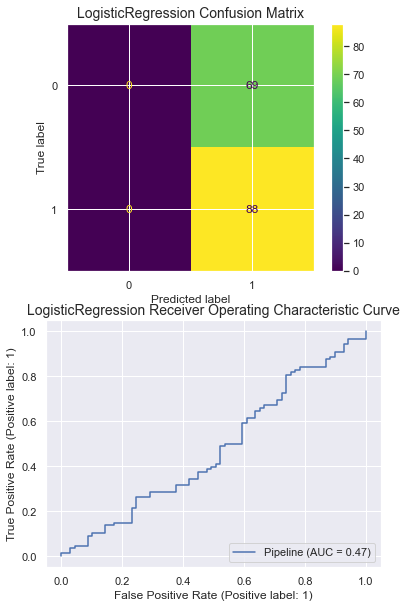

In [180]:
pipe_lr = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(random_state=1, max_iter=500))
])
print(pipe_lr)

params_grid_lr = {'lr__penalty' : ['l1', 'l2','elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=4, n_jobs=-1)

lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train.columns, best_lr_clf, 'LogisticRegression', X_test, y_test, binary=True)
Audio(sound_file, autoplay=True)

In [2]:
best_lr_clf

NameError: name 'best_lr_clf' is not defined

## Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



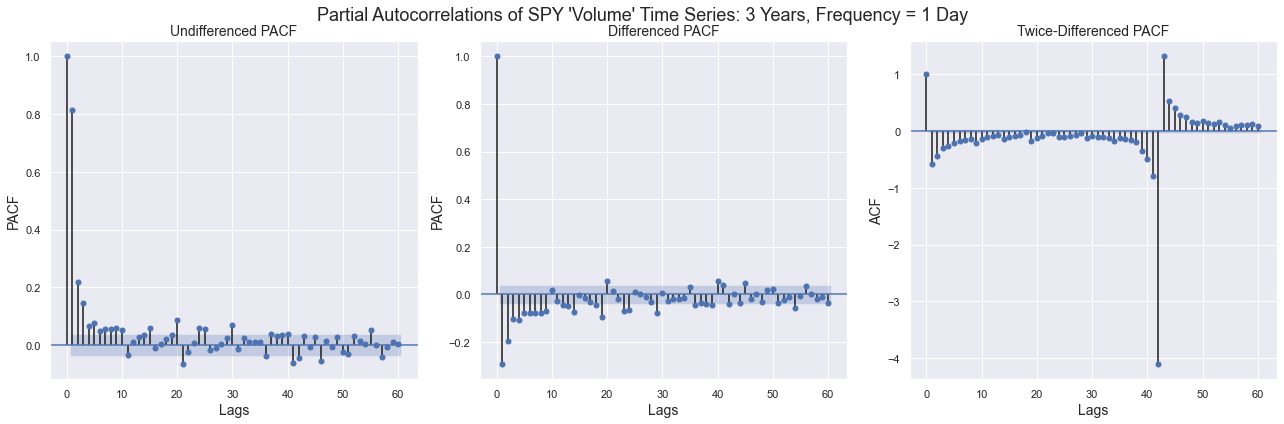

In [351]:
plot_pacf_with_diff(df_full_10Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

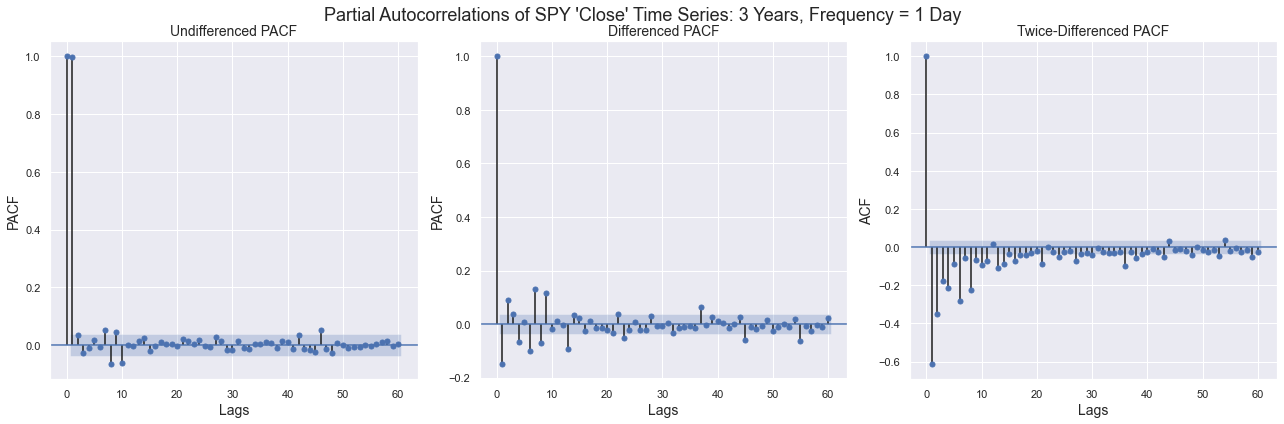

In [352]:
plot_pacf_with_diff(df_full_10Y_close.interpolate(), 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot ACF

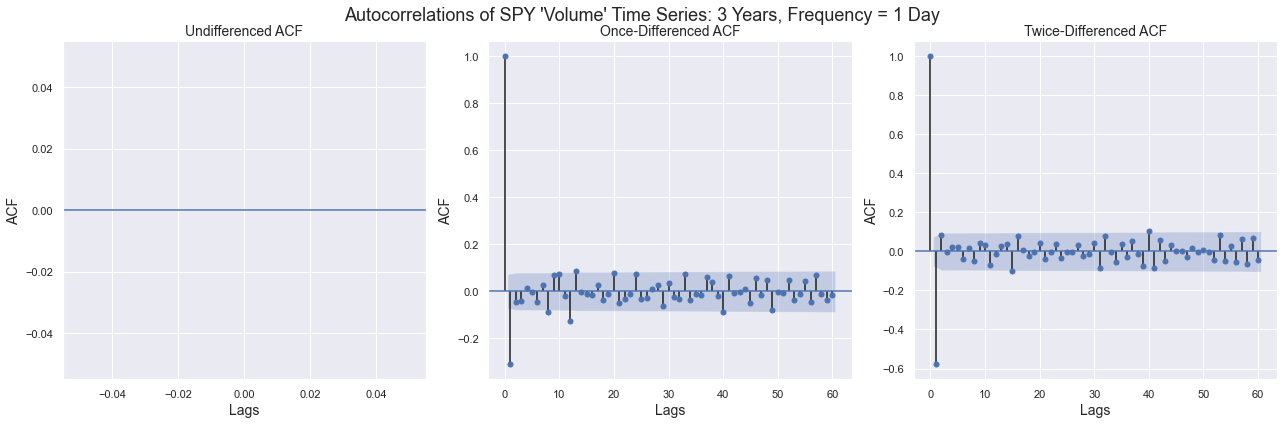

In [21]:
plot_acf_with_diff(df_full_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

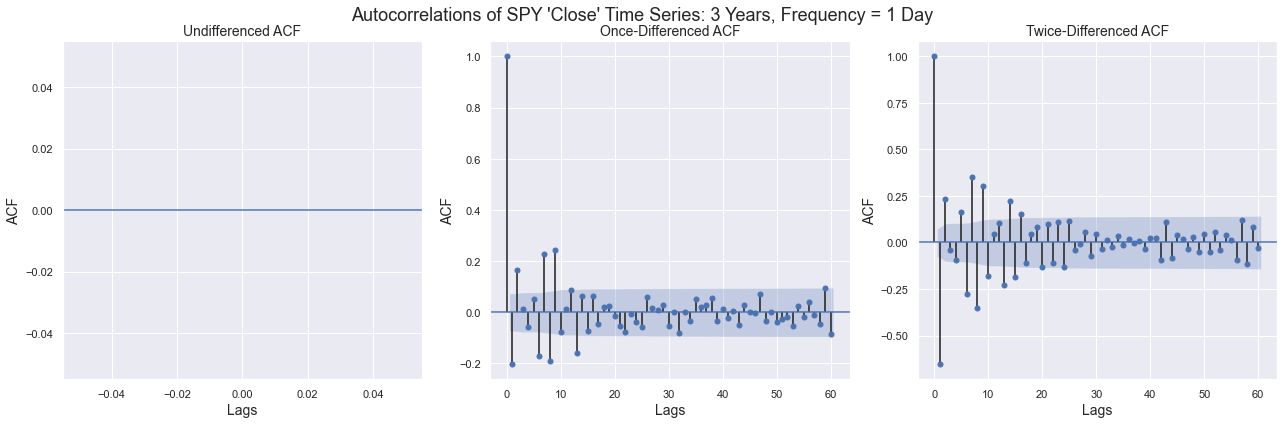

In [22]:
plot_acf_with_diff(df_full_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot Seasonal Decomposition

### 3 Years, Freq = Custom Business Day, Yearly Seasonality

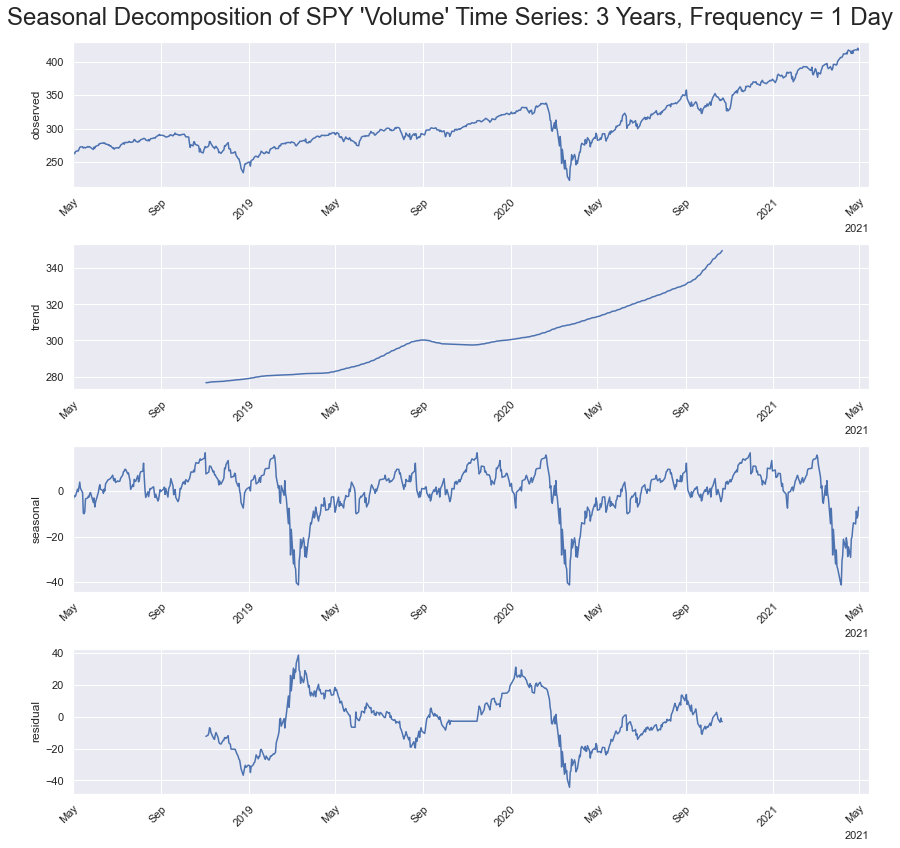

In [23]:
plot_seasonal_decomposition(df_full_3Y_close.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

### 5 Years, Freq = Custom Business Day, Yearly Seasonality

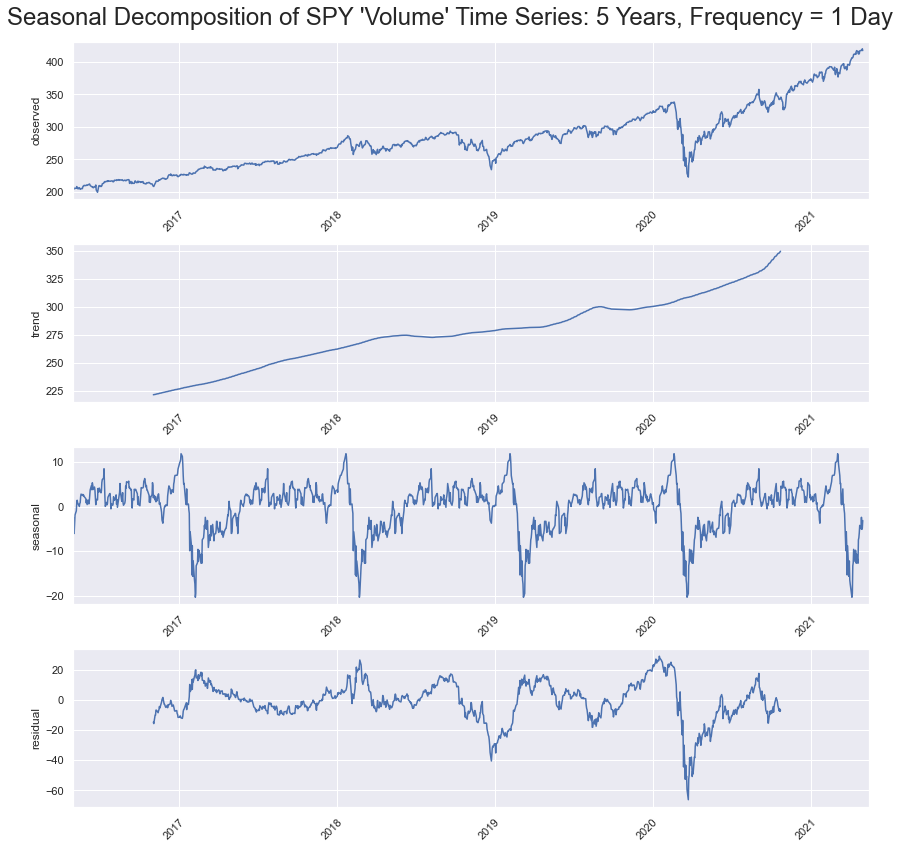

In [24]:
plot_seasonal_decomposition(df_full_5Y_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 261)

### 10 Years, Freq = Custom Business Day, Yearly Seasonality

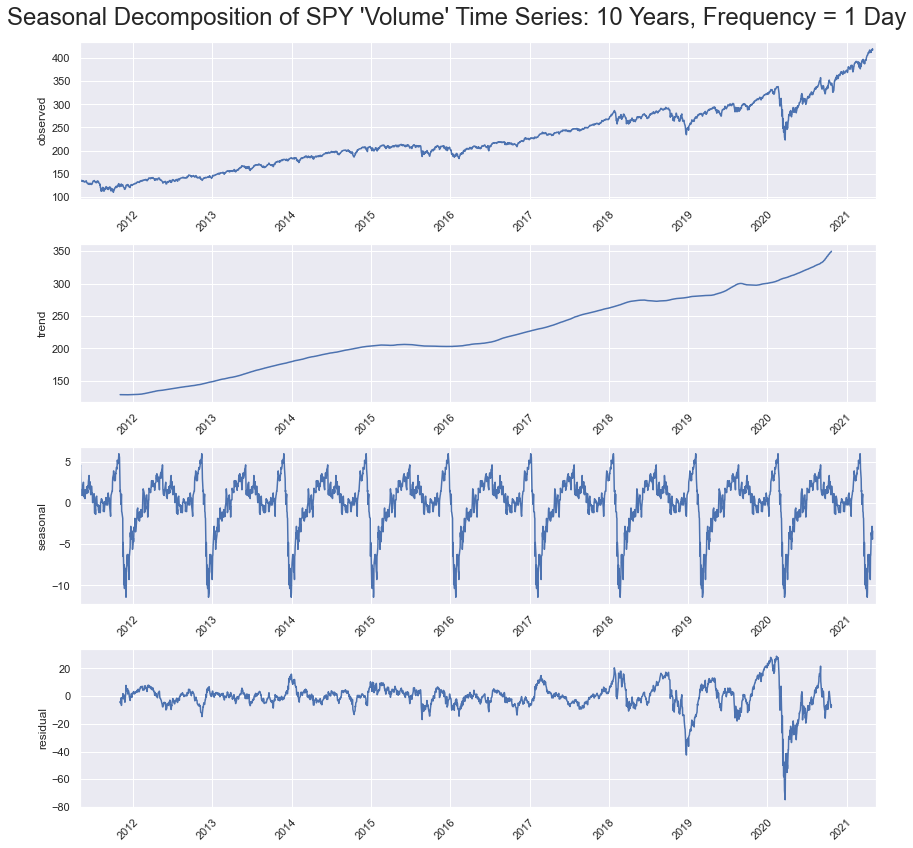

In [25]:
plot_seasonal_decomposition(df_full_10Y_close.dropna(), 'SPY \'Volume\'', 10, 'years', '1 Day', 261)